# VGG8B - CIFAR-10

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_CNN, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [4]:
architecture = [
    ('Conv2d', 128, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 256, 3, 1, 1),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
]
num_fc_layers = 2
num_fc_hidden = [1024]

In [5]:
dataset_config = dict(
    dataset=Dataset.CIFAR10.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=True,
    normalize=True,
)

In [6]:
network_config = dict(
    architecture=architecture,
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    pred_decoder_dim=4096,
    fe_dropout_rate=0.0,
    fc_dropout_rate=0.15,
    seed=47,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    pooling_type='max',
    bias=False,
    debug=False,
)

In [7]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=25_000,
    subnet_decay_inv=3000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [8]:
config = dataset_config | network_config | training_config

## Run the configuration

Files already downloaded and verified


Files already downloaded and verified


Training on 50000 samples


Data normalized. New statistics:
-  Min: [-123 -123 -105]
-  Max: [126 127 127]
- Mean: [0 0 0]
-  Std: [61 61 61]



Moved data to device: <CUDA Device 0>
Train set:  (50000, 3, 32, 32), (50000, 10)
Test set:   (10000, 3, 32, 32), (10000, 10)
Data types: (int8, int8)


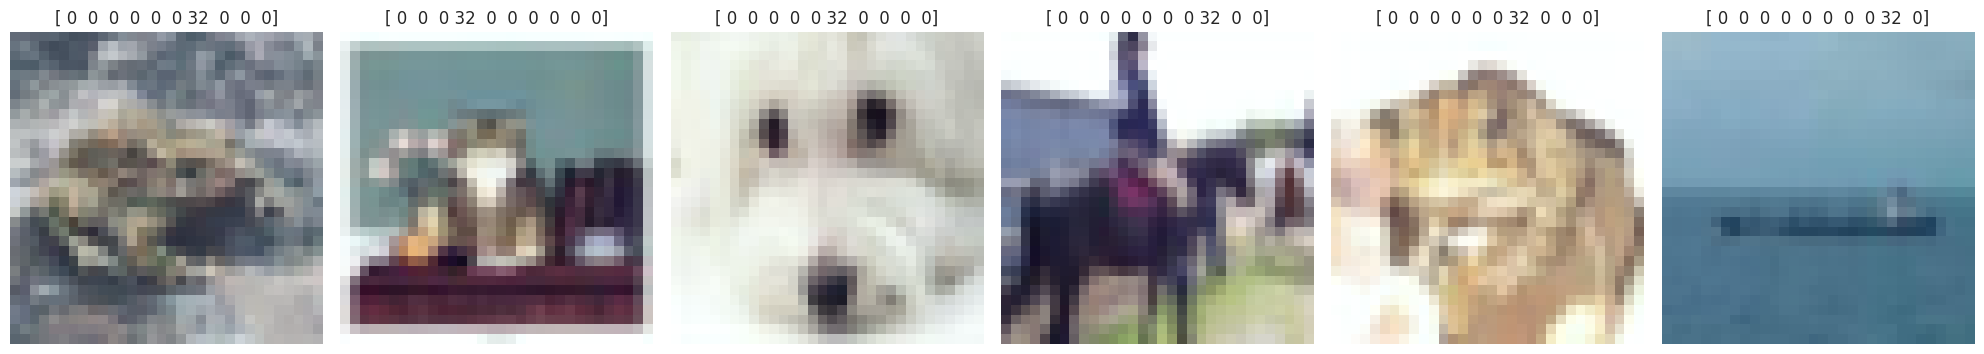

In [9]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [10]:
model = build_CNN(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossCNN(
	(0): Sequential(
			(0): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=3, out_channels=128, bias=False, decay_rate_inv=25000)
			(1): ConstantScaling(fwd_factor=6912, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 4), stride=(8, 4), padding=(0, 0))
			(1): Flatten()
			(2): IntegerLinear(in_features=4096, out_features=10, bias=False, decay_rate_inv=3000)
			(3): ConstantScaling(fwd_factor=1048576, bwd_factor=1)
		)
	)
			(1): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=128, out_channels=256, bias=False, decay_rate_inv=25000)
			(1): ConstantScaling(fwd_factor=294912, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=(0, 0))
			(1): Flatten()
			(2): IntegerLinear(in_features=4096, out_features=10, bias=False, decay_rate_inv=3000)
			(3): ConstantScaling(fwd_factor=10485

In [11]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)

    # Build and train the model
    m = build_CNN(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])

    import requests  
    tg_chat_id = '827408693'  
    tg_api_token = '6331557290:AAGQaWZP0oANCgL1_0hMiL0XQk_mT7n-tFk'  
    text = "Part 2 run complete!"  
    requests.post(f'https://api.telegram.org/bot{tg_api_token}/sendMessage', params={"chat_id":tg_chat_id, "text":text})

In [12]:
N_EXPERIMENTS = 5
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 47...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.951% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 19.708% - Test accuracy: 26.993%


Epoch   3/150 - Train accuracy: 33.631% - Test accuracy: 43.339%


Epoch   4/150 - Train accuracy: 46.681% - Test accuracy: 51.993%


Epoch   5/150 - Train accuracy: 52.887% - Test accuracy: 59.014%


Epoch   6/150 - Train accuracy: 57.666% - Test accuracy: 62.420%


Epoch   7/150 - Train accuracy: 60.869% - Test accuracy: 65.174%


Epoch   8/150 - Train accuracy: 63.952% - Test accuracy: 67.077%


Epoch   9/150 - Train accuracy: 65.175% - Test accuracy: 65.435%


Epoch  10/150 - Train accuracy: 67.228% - Test accuracy: 70.453%


Epoch  11/150 - Train accuracy: 68.896% - Test accuracy: 71.875%


Epoch  12/150 - Train accuracy: 70.300% - Test accuracy: 72.145%


Epoch  13/150 - Train accuracy: 71.335% - Test accuracy: 73.878%


Epoch  14/150 - Train accuracy: 72.445% - Test accuracy: 74.659%


Epoch  15/150 - Train accuracy: 72.879% - Test accuracy: 72.446%


Epoch  16/150 - Train accuracy: 73.808% - Test accuracy: 74.409%


Epoch  17/150 - Train accuracy: 74.330% - Test accuracy: 76.502%


Epoch  18/150 - Train accuracy: 74.800% - Test accuracy: 74.289%


Epoch  19/150 - Train accuracy: 75.666% - Test accuracy: 74.740%


Epoch  20/150 - Train accuracy: 76.186% - Test accuracy: 77.123%


Epoch  21/150 - Train accuracy: 76.581% - Test accuracy: 78.385%


Epoch  22/150 - Train accuracy: 77.119% - Test accuracy: 78.175%


Epoch  23/150 - Train accuracy: 77.427% - Test accuracy: 79.137%


Epoch  24/150 - Train accuracy: 78.437% - Test accuracy: 78.115%


Epoch  25/150 - Train accuracy: 78.533% - Test accuracy: 80.238%


Epoch  26/150 - Train accuracy: 78.667% - Test accuracy: 72.696%


Epoch  27/150 - Train accuracy: 79.183% - Test accuracy: 78.886%


Epoch  28/150 - Train accuracy: 79.325% - Test accuracy: 78.576%


Epoch  29/150 - Train accuracy: 79.507% - Test accuracy: 78.816%


Epoch  30/150 - Train accuracy: 80.320% - Test accuracy: 77.694%


Epoch  31/150 - Train accuracy: 79.996% - Test accuracy: 78.876%


Epoch  32/150 - Train accuracy: 80.762% - Test accuracy: 78.355%


Epoch  33/150 - Train accuracy: 81.116% - Test accuracy: 80.228%


Epoch  34/150 - Train accuracy: 81.282% - Test accuracy: 78.165%


Epoch  35/150 - Train accuracy: 81.120% - Test accuracy: 79.557%


Epoch  36/150 - Train accuracy: 81.568% - Test accuracy: 81.480%


Epoch  37/150 - Train accuracy: 81.816% - Test accuracy: 77.554%


Epoch  38/150 - Train accuracy: 82.130% - Test accuracy: 81.260%


Epoch  39/150 - Train accuracy: 82.150% - Test accuracy: 81.190%


Epoch  40/150 - Train accuracy: 82.330% - Test accuracy: 81.380%


Epoch  41/150 - Train accuracy: 82.398% - Test accuracy: 82.562%


Epoch  42/150 - Train accuracy: 82.766% - Test accuracy: 80.038%


Epoch  43/150 - Train accuracy: 82.859% - Test accuracy: 82.111%


Epoch  44/150 - Train accuracy: 83.219% - Test accuracy: 79.928%


Epoch  45/150 - Train accuracy: 83.127% - Test accuracy: 81.030%


Epoch  46/150 - Train accuracy: 83.113% - Test accuracy: 78.656%


Epoch  47/150 - Train accuracy: 83.697% - Test accuracy: 80.449%


Epoch  48/150 - Train accuracy: 83.565% - Test accuracy: 81.480%


Epoch  49/150 - Train accuracy: 83.651% - Test accuracy: 82.011%


Epoch  50/150 - Train accuracy: 83.539% - Test accuracy: 80.899%


Epoch  51/150 - Train accuracy: 83.871% - Test accuracy: 81.230%


Epoch  52/150 - Train accuracy: 83.903% - Test accuracy: 79.277%


Epoch  53/150 - Train accuracy: 84.473% - Test accuracy: 81.581%


Epoch  54/150 - Train accuracy: 84.709% - Test accuracy: 81.450%


Epoch  55/150 - Train accuracy: 84.577% - Test accuracy: 82.021%


Epoch  56/150 - Train accuracy: 84.027% - Test accuracy: 82.652%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 56
----------------------------------------------------------------


Epoch  57/150 - Train accuracy: 88.402% - Test accuracy: 85.497%


Epoch  58/150 - Train accuracy: 88.918% - Test accuracy: 85.236%


Epoch  59/150 - Train accuracy: 89.571% - Test accuracy: 85.887%


Epoch  60/150 - Train accuracy: 89.537% - Test accuracy: 85.737%


Epoch  61/150 - Train accuracy: 89.941% - Test accuracy: 85.467%


Epoch  62/150 - Train accuracy: 89.773% - Test accuracy: 85.657%


Epoch  63/150 - Train accuracy: 90.007% - Test accuracy: 85.387%


Epoch  64/150 - Train accuracy: 89.901% - Test accuracy: 86.188%


Epoch  65/150 - Train accuracy: 90.163% - Test accuracy: 86.428%


Epoch  66/150 - Train accuracy: 90.071% - Test accuracy: 86.128%


Epoch  67/150 - Train accuracy: 90.401% - Test accuracy: 86.078%


Epoch  68/150 - Train accuracy: 90.267% - Test accuracy: 86.108%


Epoch  69/150 - Train accuracy: 90.385% - Test accuracy: 86.338%


Epoch  70/150 - Train accuracy: 90.717% - Test accuracy: 86.158%


Epoch  71/150 - Train accuracy: 90.517% - Test accuracy: 86.318%


Epoch  72/150 - Train accuracy: 90.717% - Test accuracy: 85.286%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 72
----------------------------------------------------------------


Epoch  73/150 - Train accuracy: 91.681% - Test accuracy: 87.049%


Epoch  74/150 - Train accuracy: 91.569% - Test accuracy: 87.270%


Epoch  75/150 - Train accuracy: 91.797% - Test accuracy: 86.649%


Epoch  76/150 - Train accuracy: 92.141% - Test accuracy: 87.280%


Epoch  77/150 - Train accuracy: 91.751% - Test accuracy: 86.709%


Epoch  78/150 - Train accuracy: 91.935% - Test accuracy: 87.200%


Epoch  79/150 - Train accuracy: 91.713% - Test accuracy: 87.310%


Epoch  80/150 - Train accuracy: 91.829% - Test accuracy: 87.400%


Epoch  81/150 - Train accuracy: 92.121% - Test accuracy: 87.089%


Epoch  82/150 - Train accuracy: 92.081% - Test accuracy: 87.270%


Epoch  83/150 - Train accuracy: 92.188% - Test accuracy: 87.390%


Epoch  84/150 - Train accuracy: 92.047% - Test accuracy: 87.500%


Epoch  85/150 - Train accuracy: 92.212% - Test accuracy: 87.330%


Epoch  86/150 - Train accuracy: 92.053% - Test accuracy: 87.330%


Epoch  87/150 - Train accuracy: 92.141% - Test accuracy: 87.330%


Epoch  88/150 - Train accuracy: 92.015% - Test accuracy: 87.410%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 88
----------------------------------------------------------------


Epoch  89/150 - Train accuracy: 92.546% - Test accuracy: 87.670%


Epoch  90/150 - Train accuracy: 92.418% - Test accuracy: 87.620%


Epoch  91/150 - Train accuracy: 92.432% - Test accuracy: 87.590%


Epoch  92/150 - Train accuracy: 92.642% - Test accuracy: 87.390%


Epoch  93/150 - Train accuracy: 92.474% - Test accuracy: 87.500%


Epoch  94/150 - Train accuracy: 92.386% - Test accuracy: 87.660%


Epoch  95/150 - Train accuracy: 92.548% - Test accuracy: 87.520%


Epoch  96/150 - Train accuracy: 92.654% - Test accuracy: 87.410%


Epoch  97/150 - Train accuracy: 92.654% - Test accuracy: 87.520%


Epoch  98/150 - Train accuracy: 92.528% - Test accuracy: 87.580%


Epoch  99/150 - Train accuracy: 92.588% - Test accuracy: 87.740%


Epoch 100/150 - Train accuracy: 92.484% - Test accuracy: 87.660%


Epoch 101/150 - Train accuracy: 92.524% - Test accuracy: 87.520%


Epoch 102/150 - Train accuracy: 92.434% - Test accuracy: 87.550%


Epoch 103/150 - Train accuracy: 92.646% - Test accuracy: 87.730%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 103
----------------------------------------------------------------


Epoch 104/150 - Train accuracy: 92.784% - Test accuracy: 87.660%


Epoch 105/150 - Train accuracy: 92.668% - Test accuracy: 87.620%


Epoch 106/150 - Train accuracy: 92.688% - Test accuracy: 87.821%


Epoch 107/150 - Train accuracy: 92.722% - Test accuracy: 87.680%


Epoch 108/150 - Train accuracy: 92.686% - Test accuracy: 87.590%
----------------------------------------------------------------
Early stopping at epoch 108
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 48...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.129% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 18.326% - Test accuracy: 28.676%


Epoch   3/150 - Train accuracy: 33.799% - Test accuracy: 45.523%


Epoch   4/150 - Train accuracy: 46.041% - Test accuracy: 53.075%


Epoch   5/150 - Train accuracy: 51.761% - Test accuracy: 55.589%


Epoch   6/150 - Train accuracy: 55.958% - Test accuracy: 62.290%


Epoch   7/150 - Train accuracy: 60.245% - Test accuracy: 65.655%


Epoch   8/150 - Train accuracy: 62.806% - Test accuracy: 67.298%


Epoch   9/150 - Train accuracy: 65.071% - Test accuracy: 67.538%


Epoch  10/150 - Train accuracy: 67.049% - Test accuracy: 70.964%


Epoch  11/150 - Train accuracy: 68.482% - Test accuracy: 71.765%


Epoch  12/150 - Train accuracy: 69.888% - Test accuracy: 72.536%


Epoch  13/150 - Train accuracy: 71.111% - Test accuracy: 72.957%


Epoch  14/150 - Train accuracy: 71.871% - Test accuracy: 73.217%


Epoch  15/150 - Train accuracy: 72.765% - Test accuracy: 72.386%


Epoch  16/150 - Train accuracy: 73.588% - Test accuracy: 75.711%


Epoch  17/150 - Train accuracy: 74.362% - Test accuracy: 74.169%


Epoch  18/150 - Train accuracy: 74.854% - Test accuracy: 73.858%


Epoch  19/150 - Train accuracy: 75.590% - Test accuracy: 74.900%


Epoch  20/150 - Train accuracy: 76.068% - Test accuracy: 74.309%


Epoch  21/150 - Train accuracy: 76.705% - Test accuracy: 78.606%


Epoch  22/150 - Train accuracy: 77.095% - Test accuracy: 76.352%


Epoch  23/150 - Train accuracy: 77.349% - Test accuracy: 77.153%


Epoch  24/150 - Train accuracy: 78.307% - Test accuracy: 78.726%


Epoch  25/150 - Train accuracy: 78.323% - Test accuracy: 76.212%


Epoch  26/150 - Train accuracy: 78.989% - Test accuracy: 76.753%


Epoch  27/150 - Train accuracy: 79.033% - Test accuracy: 77.103%


Epoch  28/150 - Train accuracy: 79.283% - Test accuracy: 79.848%


Epoch  29/150 - Train accuracy: 79.529% - Test accuracy: 78.305%


Epoch  30/150 - Train accuracy: 79.862% - Test accuracy: 77.484%


Epoch  31/150 - Train accuracy: 80.130% - Test accuracy: 79.958%


Epoch  32/150 - Train accuracy: 80.290% - Test accuracy: 79.677%


Epoch  33/150 - Train accuracy: 81.018% - Test accuracy: 80.058%


Epoch  34/150 - Train accuracy: 80.634% - Test accuracy: 78.696%


Epoch  35/150 - Train accuracy: 81.350% - Test accuracy: 81.380%


Epoch  36/150 - Train accuracy: 81.506% - Test accuracy: 80.379%


Epoch  37/150 - Train accuracy: 81.454% - Test accuracy: 80.940%


Epoch  38/150 - Train accuracy: 81.762% - Test accuracy: 80.899%


Epoch  39/150 - Train accuracy: 81.946% - Test accuracy: 80.479%


Epoch  40/150 - Train accuracy: 82.022% - Test accuracy: 77.764%


Epoch  41/150 - Train accuracy: 82.430% - Test accuracy: 81.230%


Epoch  42/150 - Train accuracy: 82.784% - Test accuracy: 79.537%


Epoch  43/150 - Train accuracy: 82.720% - Test accuracy: 81.811%


Epoch  44/150 - Train accuracy: 82.957% - Test accuracy: 81.801%


Epoch  45/150 - Train accuracy: 82.949% - Test accuracy: 79.347%


Epoch  46/150 - Train accuracy: 83.033% - Test accuracy: 81.260%


Epoch  47/150 - Train accuracy: 83.311% - Test accuracy: 82.442%


Epoch  48/150 - Train accuracy: 83.595% - Test accuracy: 79.537%


Epoch  49/150 - Train accuracy: 83.699% - Test accuracy: 82.031%


Epoch  50/150 - Train accuracy: 83.413% - Test accuracy: 82.141%


Epoch  51/150 - Train accuracy: 84.117% - Test accuracy: 82.362%


Epoch  52/150 - Train accuracy: 84.287% - Test accuracy: 81.901%


Epoch  53/150 - Train accuracy: 84.161% - Test accuracy: 79.537%


Epoch  54/150 - Train accuracy: 84.037% - Test accuracy: 81.510%


Epoch  55/150 - Train accuracy: 84.061% - Test accuracy: 82.312%


Epoch  56/150 - Train accuracy: 84.083% - Test accuracy: 81.010%


Epoch  57/150 - Train accuracy: 84.557% - Test accuracy: 81.831%


Epoch  58/150 - Train accuracy: 84.681% - Test accuracy: 82.051%


Epoch  59/150 - Train accuracy: 84.765% - Test accuracy: 81.320%


Epoch  60/150 - Train accuracy: 84.919% - Test accuracy: 83.013%


Epoch  61/150 - Train accuracy: 85.035% - Test accuracy: 81.691%


Epoch  62/150 - Train accuracy: 84.963% - Test accuracy: 81.050%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 62
----------------------------------------------------------------


Epoch  63/150 - Train accuracy: 88.652% - Test accuracy: 85.547%


Epoch  64/150 - Train accuracy: 89.605% - Test accuracy: 85.447%


Epoch  65/150 - Train accuracy: 89.705% - Test accuracy: 85.767%


Epoch  66/150 - Train accuracy: 90.009% - Test accuracy: 85.226%


Epoch  67/150 - Train accuracy: 90.211% - Test accuracy: 85.437%


Epoch  68/150 - Train accuracy: 90.143% - Test accuracy: 85.357%


Epoch  69/150 - Train accuracy: 90.389% - Test accuracy: 86.518%


Epoch  70/150 - Train accuracy: 90.541% - Test accuracy: 86.278%


Epoch  71/150 - Train accuracy: 90.527% - Test accuracy: 86.188%


Epoch  72/150 - Train accuracy: 90.641% - Test accuracy: 86.428%


Epoch  73/150 - Train accuracy: 90.663% - Test accuracy: 86.538%


Epoch  74/150 - Train accuracy: 90.607% - Test accuracy: 86.548%


Epoch  75/150 - Train accuracy: 90.973% - Test accuracy: 86.148%


Epoch  76/150 - Train accuracy: 90.861% - Test accuracy: 86.558%


Epoch  77/150 - Train accuracy: 90.977% - Test accuracy: 86.629%


Epoch  78/150 - Train accuracy: 90.809% - Test accuracy: 86.599%


Epoch  79/150 - Train accuracy: 91.183% - Test accuracy: 86.248%


Epoch  80/150 - Train accuracy: 91.319% - Test accuracy: 86.579%


Epoch  81/150 - Train accuracy: 91.015% - Test accuracy: 86.599%


Epoch  82/150 - Train accuracy: 91.165% - Test accuracy: 85.457%


Epoch  83/150 - Train accuracy: 91.111% - Test accuracy: 86.188%


Epoch  84/150 - Train accuracy: 91.227% - Test accuracy: 86.258%


Epoch  85/150 - Train accuracy: 91.319% - Test accuracy: 86.849%


Epoch  86/150 - Train accuracy: 91.439% - Test accuracy: 85.216%


Epoch  87/150 - Train accuracy: 91.443% - Test accuracy: 86.398%


Epoch  88/150 - Train accuracy: 91.369% - Test accuracy: 86.769%


Epoch  89/150 - Train accuracy: 91.285% - Test accuracy: 86.478%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 89
----------------------------------------------------------------


Epoch  90/150 - Train accuracy: 92.596% - Test accuracy: 87.760%


Epoch  91/150 - Train accuracy: 92.656% - Test accuracy: 87.740%


Epoch  92/150 - Train accuracy: 92.754% - Test accuracy: 87.750%


Epoch  93/150 - Train accuracy: 92.934% - Test accuracy: 87.971%


Epoch  94/150 - Train accuracy: 92.960% - Test accuracy: 87.360%


Epoch  95/150 - Train accuracy: 93.032% - Test accuracy: 87.790%


Epoch  96/150 - Train accuracy: 92.864% - Test accuracy: 87.720%


Epoch  97/150 - Train accuracy: 93.116% - Test accuracy: 87.841%


Epoch  98/150 - Train accuracy: 93.012% - Test accuracy: 87.640%


Epoch  99/150 - Train accuracy: 92.960% - Test accuracy: 87.460%


Epoch 100/150 - Train accuracy: 93.150% - Test accuracy: 87.871%


Epoch 101/150 - Train accuracy: 93.050% - Test accuracy: 87.831%


Epoch 102/150 - Train accuracy: 93.008% - Test accuracy: 87.710%


Epoch 103/150 - Train accuracy: 93.340% - Test accuracy: 87.570%


Epoch 104/150 - Train accuracy: 93.178% - Test accuracy: 87.680%


Epoch 105/150 - Train accuracy: 93.256% - Test accuracy: 87.590%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 105
----------------------------------------------------------------


Epoch 106/150 - Train accuracy: 93.392% - Test accuracy: 88.041%


Epoch 107/150 - Train accuracy: 93.616% - Test accuracy: 87.730%


Epoch 108/150 - Train accuracy: 93.564% - Test accuracy: 88.081%


Epoch 109/150 - Train accuracy: 93.534% - Test accuracy: 87.881%


Epoch 110/150 - Train accuracy: 93.566% - Test accuracy: 87.821%


Epoch 111/150 - Train accuracy: 93.614% - Test accuracy: 88.001%


Epoch 112/150 - Train accuracy: 93.394% - Test accuracy: 87.881%


Epoch 113/150 - Train accuracy: 93.408% - Test accuracy: 87.670%


Epoch 114/150 - Train accuracy: 93.580% - Test accuracy: 88.011%


Epoch 115/150 - Train accuracy: 93.540% - Test accuracy: 87.961%


Epoch 116/150 - Train accuracy: 93.762% - Test accuracy: 87.901%


Epoch 117/150 - Train accuracy: 93.770% - Test accuracy: 87.871%


Epoch 118/150 - Train accuracy: 93.650% - Test accuracy: 87.891%


Epoch 119/150 - Train accuracy: 93.520% - Test accuracy: 87.981%


Epoch 120/150 - Train accuracy: 93.652% - Test accuracy: 88.051%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 120
----------------------------------------------------------------


Epoch 121/150 - Train accuracy: 93.762% - Test accuracy: 88.131%


Epoch 122/150 - Train accuracy: 93.786% - Test accuracy: 88.091%


Epoch 123/150 - Train accuracy: 93.630% - Test accuracy: 88.181%


Epoch 124/150 - Train accuracy: 93.778% - Test accuracy: 88.151%


Epoch 125/150 - Train accuracy: 93.854% - Test accuracy: 88.011%
----------------------------------------------------------------
Early stopping at epoch 125
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 49...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.937% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 20.036% - Test accuracy: 28.886%


Epoch   3/150 - Train accuracy: 36.350% - Test accuracy: 46.024%


Epoch   4/150 - Train accuracy: 46.565% - Test accuracy: 54.347%


Epoch   5/150 - Train accuracy: 51.935% - Test accuracy: 55.869%


Epoch   6/150 - Train accuracy: 56.820% - Test accuracy: 58.584%


Epoch   7/150 - Train accuracy: 60.687% - Test accuracy: 63.431%


Epoch   8/150 - Train accuracy: 63.512% - Test accuracy: 63.452%


Epoch   9/150 - Train accuracy: 65.653% - Test accuracy: 62.149%


Epoch  10/150 - Train accuracy: 67.540% - Test accuracy: 68.059%


Epoch  11/150 - Train accuracy: 68.898% - Test accuracy: 70.062%


Epoch  12/150 - Train accuracy: 70.094% - Test accuracy: 72.436%


Epoch  13/150 - Train accuracy: 71.443% - Test accuracy: 73.858%


Epoch  14/150 - Train accuracy: 71.989% - Test accuracy: 70.813%


Epoch  15/150 - Train accuracy: 72.897% - Test accuracy: 74.950%


Epoch  16/150 - Train accuracy: 73.978% - Test accuracy: 75.240%


Epoch  17/150 - Train accuracy: 74.172% - Test accuracy: 73.978%


Epoch  18/150 - Train accuracy: 75.084% - Test accuracy: 75.000%


Epoch  19/150 - Train accuracy: 75.908% - Test accuracy: 75.020%


Epoch  20/150 - Train accuracy: 75.954% - Test accuracy: 76.312%


Epoch  21/150 - Train accuracy: 76.895% - Test accuracy: 77.905%


Epoch  22/150 - Train accuracy: 76.999% - Test accuracy: 78.305%


Epoch  23/150 - Train accuracy: 77.301% - Test accuracy: 77.794%


Epoch  24/150 - Train accuracy: 78.361% - Test accuracy: 76.863%


Epoch  25/150 - Train accuracy: 78.129% - Test accuracy: 79.798%


Epoch  26/150 - Train accuracy: 78.851% - Test accuracy: 78.115%


Epoch  27/150 - Train accuracy: 79.149% - Test accuracy: 76.783%


Epoch  28/150 - Train accuracy: 79.599% - Test accuracy: 80.158%


Epoch  29/150 - Train accuracy: 79.756% - Test accuracy: 77.324%


Epoch  30/150 - Train accuracy: 80.126% - Test accuracy: 78.285%


Epoch  31/150 - Train accuracy: 80.844% - Test accuracy: 80.369%


Epoch  32/150 - Train accuracy: 80.636% - Test accuracy: 79.928%


Epoch  33/150 - Train accuracy: 81.052% - Test accuracy: 80.108%


Epoch  34/150 - Train accuracy: 81.292% - Test accuracy: 79.127%


Epoch  35/150 - Train accuracy: 81.464% - Test accuracy: 77.664%


Epoch  36/150 - Train accuracy: 81.174% - Test accuracy: 79.497%


Epoch  37/150 - Train accuracy: 81.858% - Test accuracy: 80.399%


Epoch  38/150 - Train accuracy: 81.714% - Test accuracy: 80.729%


Epoch  39/150 - Train accuracy: 82.018% - Test accuracy: 80.509%


Epoch  40/150 - Train accuracy: 82.306% - Test accuracy: 81.000%


Epoch  41/150 - Train accuracy: 82.392% - Test accuracy: 81.601%


Epoch  42/150 - Train accuracy: 82.456% - Test accuracy: 77.153%


Epoch  43/150 - Train accuracy: 82.542% - Test accuracy: 79.557%


Epoch  44/150 - Train accuracy: 82.961% - Test accuracy: 80.529%


Epoch  45/150 - Train accuracy: 82.923% - Test accuracy: 78.936%


Epoch  46/150 - Train accuracy: 83.257% - Test accuracy: 80.258%


Epoch  47/150 - Train accuracy: 83.279% - Test accuracy: 81.951%


Epoch  48/150 - Train accuracy: 83.353% - Test accuracy: 81.571%


Epoch  49/150 - Train accuracy: 83.741% - Test accuracy: 80.559%


Epoch  50/150 - Train accuracy: 83.859% - Test accuracy: 82.372%


Epoch  51/150 - Train accuracy: 84.009% - Test accuracy: 80.148%


Epoch  52/150 - Train accuracy: 84.095% - Test accuracy: 82.362%


Epoch  53/150 - Train accuracy: 84.201% - Test accuracy: 80.549%


Epoch  54/150 - Train accuracy: 84.125% - Test accuracy: 81.500%


Epoch  55/150 - Train accuracy: 84.509% - Test accuracy: 80.749%


Epoch  56/150 - Train accuracy: 83.967% - Test accuracy: 81.220%


Epoch  57/150 - Train accuracy: 84.543% - Test accuracy: 82.552%


Epoch  58/150 - Train accuracy: 84.689% - Test accuracy: 81.020%


Epoch  59/150 - Train accuracy: 84.843% - Test accuracy: 82.943%


Epoch  60/150 - Train accuracy: 84.851% - Test accuracy: 82.232%


Epoch  61/150 - Train accuracy: 84.891% - Test accuracy: 82.452%


Epoch  62/150 - Train accuracy: 85.097% - Test accuracy: 83.514%


Epoch  63/150 - Train accuracy: 84.931% - Test accuracy: 82.462%


Epoch  64/150 - Train accuracy: 85.095% - Test accuracy: 82.542%


Epoch  65/150 - Train accuracy: 85.167% - Test accuracy: 80.419%


Epoch  66/150 - Train accuracy: 85.217% - Test accuracy: 83.373%


Epoch  67/150 - Train accuracy: 85.389% - Test accuracy: 80.819%


Epoch  68/150 - Train accuracy: 85.559% - Test accuracy: 82.352%


Epoch  69/150 - Train accuracy: 85.519% - Test accuracy: 81.120%


Epoch  70/150 - Train accuracy: 85.667% - Test accuracy: 82.141%


Epoch  71/150 - Train accuracy: 85.731% - Test accuracy: 81.931%


Epoch  72/150 - Train accuracy: 86.138% - Test accuracy: 82.051%


Epoch  73/150 - Train accuracy: 85.887% - Test accuracy: 82.041%


Epoch  74/150 - Train accuracy: 85.855% - Test accuracy: 82.262%


Epoch  75/150 - Train accuracy: 86.266% - Test accuracy: 82.602%


Epoch  76/150 - Train accuracy: 86.168% - Test accuracy: 82.903%


Epoch  77/150 - Train accuracy: 86.146% - Test accuracy: 84.235%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 77
----------------------------------------------------------------


Epoch  78/150 - Train accuracy: 90.003% - Test accuracy: 85.146%


Epoch  79/150 - Train accuracy: 90.355% - Test accuracy: 86.468%


Epoch  80/150 - Train accuracy: 91.169% - Test accuracy: 86.438%


Epoch  81/150 - Train accuracy: 91.027% - Test accuracy: 86.128%


Epoch  82/150 - Train accuracy: 91.161% - Test accuracy: 86.408%


Epoch  83/150 - Train accuracy: 91.267% - Test accuracy: 86.839%


Epoch  84/150 - Train accuracy: 91.307% - Test accuracy: 86.158%


Epoch  85/150 - Train accuracy: 91.631% - Test accuracy: 86.508%


Epoch  86/150 - Train accuracy: 91.769% - Test accuracy: 86.879%


Epoch  87/150 - Train accuracy: 91.507% - Test accuracy: 87.029%


Epoch  88/150 - Train accuracy: 91.845% - Test accuracy: 86.569%


Epoch  89/150 - Train accuracy: 91.865% - Test accuracy: 86.739%


Epoch  90/150 - Train accuracy: 91.755% - Test accuracy: 86.819%


Epoch  91/150 - Train accuracy: 91.801% - Test accuracy: 86.528%


Epoch  92/150 - Train accuracy: 91.831% - Test accuracy: 86.508%


Epoch  93/150 - Train accuracy: 91.959% - Test accuracy: 87.270%


Epoch  94/150 - Train accuracy: 91.957% - Test accuracy: 86.969%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 94
----------------------------------------------------------------


Epoch  95/150 - Train accuracy: 93.070% - Test accuracy: 87.530%


Epoch  96/150 - Train accuracy: 93.264% - Test accuracy: 87.570%


Epoch  97/150 - Train accuracy: 93.278% - Test accuracy: 87.520%


Epoch  98/150 - Train accuracy: 93.150% - Test accuracy: 87.570%


Epoch  99/150 - Train accuracy: 93.286% - Test accuracy: 87.831%


Epoch 100/150 - Train accuracy: 93.320% - Test accuracy: 87.610%


Epoch 101/150 - Train accuracy: 93.408% - Test accuracy: 87.380%


Epoch 102/150 - Train accuracy: 93.416% - Test accuracy: 87.720%


Epoch 103/150 - Train accuracy: 93.428% - Test accuracy: 87.740%


Epoch 104/150 - Train accuracy: 93.608% - Test accuracy: 87.871%


Epoch 105/150 - Train accuracy: 93.418% - Test accuracy: 88.001%


Epoch 106/150 - Train accuracy: 93.374% - Test accuracy: 87.851%


Epoch 107/150 - Train accuracy: 93.650% - Test accuracy: 87.470%


Epoch 108/150 - Train accuracy: 93.282% - Test accuracy: 87.730%


Epoch 109/150 - Train accuracy: 93.386% - Test accuracy: 87.670%


Epoch 110/150 - Train accuracy: 93.638% - Test accuracy: 87.700%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 110
----------------------------------------------------------------


Epoch 111/150 - Train accuracy: 93.772% - Test accuracy: 88.091%


Epoch 112/150 - Train accuracy: 93.830% - Test accuracy: 88.131%


Epoch 113/150 - Train accuracy: 93.914% - Test accuracy: 87.881%


Epoch 114/150 - Train accuracy: 93.940% - Test accuracy: 88.131%


Epoch 115/150 - Train accuracy: 93.740% - Test accuracy: 87.961%


Epoch 116/150 - Train accuracy: 93.792% - Test accuracy: 87.951%


Epoch 117/150 - Train accuracy: 94.074% - Test accuracy: 87.931%


Epoch 118/150 - Train accuracy: 93.746% - Test accuracy: 87.951%


Epoch 119/150 - Train accuracy: 93.892% - Test accuracy: 88.001%


Epoch 120/150 - Train accuracy: 94.072% - Test accuracy: 88.131%


Epoch 121/150 - Train accuracy: 93.868% - Test accuracy: 88.091%


Epoch 122/150 - Train accuracy: 93.778% - Test accuracy: 88.111%


Epoch 123/150 - Train accuracy: 93.812% - Test accuracy: 88.011%


Epoch 124/150 - Train accuracy: 93.910% - Test accuracy: 87.891%


Epoch 125/150 - Train accuracy: 93.978% - Test accuracy: 87.831%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 125
----------------------------------------------------------------


Epoch 126/150 - Train accuracy: 94.058% - Test accuracy: 88.061%


Epoch 127/150 - Train accuracy: 93.880% - Test accuracy: 88.041%


Epoch 128/150 - Train accuracy: 94.160% - Test accuracy: 88.031%


Epoch 129/150 - Train accuracy: 94.080% - Test accuracy: 88.091%


Epoch 130/150 - Train accuracy: 94.108% - Test accuracy: 88.141%
----------------------------------------------------------------
Early stopping at epoch 130
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 50...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.129% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 18.162% - Test accuracy: 25.310%


Epoch   3/150 - Train accuracy: 32.931% - Test accuracy: 47.246%


Epoch   4/150 - Train accuracy: 46.377% - Test accuracy: 51.562%


Epoch   5/150 - Train accuracy: 51.765% - Test accuracy: 56.110%


Epoch   6/150 - Train accuracy: 56.822% - Test accuracy: 60.988%


Epoch   7/150 - Train accuracy: 60.639% - Test accuracy: 63.792%


Epoch   8/150 - Train accuracy: 63.172% - Test accuracy: 64.423%


Epoch   9/150 - Train accuracy: 65.473% - Test accuracy: 64.964%


Epoch  10/150 - Train accuracy: 67.063% - Test accuracy: 69.171%


Epoch  11/150 - Train accuracy: 68.848% - Test accuracy: 70.703%


Epoch  12/150 - Train accuracy: 69.700% - Test accuracy: 71.104%


Epoch  13/150 - Train accuracy: 71.105% - Test accuracy: 72.246%


Epoch  14/150 - Train accuracy: 72.129% - Test accuracy: 75.671%


Epoch  15/150 - Train accuracy: 73.063% - Test accuracy: 73.938%


Epoch  16/150 - Train accuracy: 73.612% - Test accuracy: 74.710%


Epoch  17/150 - Train accuracy: 74.388% - Test accuracy: 75.491%


Epoch  18/150 - Train accuracy: 74.924% - Test accuracy: 73.788%


Epoch  19/150 - Train accuracy: 75.628% - Test accuracy: 76.102%


Epoch  20/150 - Train accuracy: 76.308% - Test accuracy: 76.512%


Epoch  21/150 - Train accuracy: 76.402% - Test accuracy: 76.793%


Epoch  22/150 - Train accuracy: 76.861% - Test accuracy: 76.993%


Epoch  23/150 - Train accuracy: 77.421% - Test accuracy: 78.476%


Epoch  24/150 - Train accuracy: 77.833% - Test accuracy: 77.584%


Epoch  25/150 - Train accuracy: 78.585% - Test accuracy: 79.647%


Epoch  26/150 - Train accuracy: 78.707% - Test accuracy: 79.357%


Epoch  27/150 - Train accuracy: 79.201% - Test accuracy: 77.604%


Epoch  28/150 - Train accuracy: 79.153% - Test accuracy: 77.905%


Epoch  29/150 - Train accuracy: 79.950% - Test accuracy: 79.367%


Epoch  30/150 - Train accuracy: 79.984% - Test accuracy: 74.890%


Epoch  31/150 - Train accuracy: 80.404% - Test accuracy: 81.490%


Epoch  32/150 - Train accuracy: 80.476% - Test accuracy: 79.938%


Epoch  33/150 - Train accuracy: 80.782% - Test accuracy: 78.115%


Epoch  34/150 - Train accuracy: 81.280% - Test accuracy: 80.819%


Epoch  35/150 - Train accuracy: 81.344% - Test accuracy: 79.988%


Epoch  36/150 - Train accuracy: 81.584% - Test accuracy: 79.257%


Epoch  37/150 - Train accuracy: 81.818% - Test accuracy: 81.721%


Epoch  38/150 - Train accuracy: 81.986% - Test accuracy: 80.278%


Epoch  39/150 - Train accuracy: 81.854% - Test accuracy: 80.419%


Epoch  40/150 - Train accuracy: 82.012% - Test accuracy: 79.637%


Epoch  41/150 - Train accuracy: 82.160% - Test accuracy: 81.460%


Epoch  42/150 - Train accuracy: 82.664% - Test accuracy: 81.000%


Epoch  43/150 - Train accuracy: 82.740% - Test accuracy: 81.591%


Epoch  44/150 - Train accuracy: 83.237% - Test accuracy: 82.101%


Epoch  45/150 - Train accuracy: 82.983% - Test accuracy: 79.297%


Epoch  46/150 - Train accuracy: 83.377% - Test accuracy: 81.470%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 46
----------------------------------------------------------------


Epoch  47/150 - Train accuracy: 87.354% - Test accuracy: 84.866%


Epoch  48/150 - Train accuracy: 87.914% - Test accuracy: 85.176%


Epoch  49/150 - Train accuracy: 88.308% - Test accuracy: 85.076%


Epoch  50/150 - Train accuracy: 88.584% - Test accuracy: 85.276%


Epoch  51/150 - Train accuracy: 88.558% - Test accuracy: 85.246%


Epoch  52/150 - Train accuracy: 88.732% - Test accuracy: 85.196%


Epoch  53/150 - Train accuracy: 89.010% - Test accuracy: 85.877%


Epoch  54/150 - Train accuracy: 88.908% - Test accuracy: 85.737%


Epoch  55/150 - Train accuracy: 88.896% - Test accuracy: 85.697%


Epoch  56/150 - Train accuracy: 89.341% - Test accuracy: 85.777%


Epoch  57/150 - Train accuracy: 89.131% - Test accuracy: 85.847%


Epoch  58/150 - Train accuracy: 89.271% - Test accuracy: 85.787%


Epoch  59/150 - Train accuracy: 89.411% - Test accuracy: 86.258%


Epoch  60/150 - Train accuracy: 89.405% - Test accuracy: 86.579%


Epoch  61/150 - Train accuracy: 89.637% - Test accuracy: 85.938%


Epoch  62/150 - Train accuracy: 89.693% - Test accuracy: 86.579%


Epoch  63/150 - Train accuracy: 89.927% - Test accuracy: 86.118%


Epoch  64/150 - Train accuracy: 89.759% - Test accuracy: 86.028%


Epoch  65/150 - Train accuracy: 89.937% - Test accuracy: 86.078%


Epoch  66/150 - Train accuracy: 90.049% - Test accuracy: 86.318%


Epoch  67/150 - Train accuracy: 90.153% - Test accuracy: 86.328%


Epoch  68/150 - Train accuracy: 89.979% - Test accuracy: 85.457%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 68
----------------------------------------------------------------


Epoch  69/150 - Train accuracy: 91.373% - Test accuracy: 87.069%


Epoch  70/150 - Train accuracy: 91.369% - Test accuracy: 87.200%


Epoch  71/150 - Train accuracy: 91.497% - Test accuracy: 87.290%


Epoch  72/150 - Train accuracy: 91.625% - Test accuracy: 86.859%


Epoch  73/150 - Train accuracy: 91.381% - Test accuracy: 87.069%


Epoch  74/150 - Train accuracy: 91.739% - Test accuracy: 87.410%


Epoch  75/150 - Train accuracy: 91.389% - Test accuracy: 87.310%


Epoch  76/150 - Train accuracy: 91.853% - Test accuracy: 87.360%


Epoch  77/150 - Train accuracy: 91.757% - Test accuracy: 87.440%


Epoch  78/150 - Train accuracy: 91.813% - Test accuracy: 87.290%


Epoch  79/150 - Train accuracy: 91.873% - Test accuracy: 87.250%


Epoch  80/150 - Train accuracy: 91.693% - Test accuracy: 87.169%


Epoch  81/150 - Train accuracy: 91.857% - Test accuracy: 87.179%


Epoch  82/150 - Train accuracy: 91.869% - Test accuracy: 87.430%


Epoch  83/150 - Train accuracy: 91.727% - Test accuracy: 87.600%


Epoch  84/150 - Train accuracy: 91.837% - Test accuracy: 87.560%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 84
----------------------------------------------------------------


Epoch  85/150 - Train accuracy: 92.308% - Test accuracy: 87.841%


Epoch  86/150 - Train accuracy: 92.127% - Test accuracy: 87.750%


Epoch  87/150 - Train accuracy: 92.185% - Test accuracy: 87.590%


Epoch  88/150 - Train accuracy: 92.294% - Test accuracy: 87.871%


Epoch  89/150 - Train accuracy: 92.448% - Test accuracy: 87.790%


Epoch  90/150 - Train accuracy: 92.326% - Test accuracy: 87.670%


Epoch  91/150 - Train accuracy: 92.396% - Test accuracy: 87.740%


Epoch  92/150 - Train accuracy: 92.414% - Test accuracy: 87.720%


Epoch  93/150 - Train accuracy: 92.392% - Test accuracy: 87.720%


Epoch  94/150 - Train accuracy: 92.232% - Test accuracy: 87.580%


Epoch  95/150 - Train accuracy: 92.177% - Test accuracy: 87.520%


Epoch  96/150 - Train accuracy: 92.372% - Test accuracy: 87.690%


Epoch  97/150 - Train accuracy: 92.268% - Test accuracy: 87.700%


Epoch  98/150 - Train accuracy: 92.322% - Test accuracy: 87.480%


Epoch  99/150 - Train accuracy: 92.300% - Test accuracy: 87.790%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 99
----------------------------------------------------------------


Epoch 100/150 - Train accuracy: 92.466% - Test accuracy: 87.670%


Epoch 101/150 - Train accuracy: 92.466% - Test accuracy: 87.831%


Epoch 102/150 - Train accuracy: 92.394% - Test accuracy: 87.871%


Epoch 103/150 - Train accuracy: 92.462% - Test accuracy: 87.921%


Epoch 104/150 - Train accuracy: 92.614% - Test accuracy: 87.881%
----------------------------------------------------------------
Early stopping at epoch 104
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 51...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.957% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 19.650% - Test accuracy: 30.339%


Epoch   3/150 - Train accuracy: 36.632% - Test accuracy: 46.074%


Epoch   4/150 - Train accuracy: 46.225% - Test accuracy: 54.497%


Epoch   5/150 - Train accuracy: 52.053% - Test accuracy: 54.437%


Epoch   6/150 - Train accuracy: 56.522% - Test accuracy: 62.009%


Epoch   7/150 - Train accuracy: 60.803% - Test accuracy: 65.525%


Epoch   8/150 - Train accuracy: 63.090% - Test accuracy: 63.602%


Epoch   9/150 - Train accuracy: 65.421% - Test accuracy: 64.103%


Epoch  10/150 - Train accuracy: 66.999% - Test accuracy: 69.391%


Epoch  11/150 - Train accuracy: 68.494% - Test accuracy: 69.371%


Epoch  12/150 - Train accuracy: 69.838% - Test accuracy: 72.175%


Epoch  13/150 - Train accuracy: 70.705% - Test accuracy: 72.626%


Epoch  14/150 - Train accuracy: 72.197% - Test accuracy: 73.197%


Epoch  15/150 - Train accuracy: 72.873% - Test accuracy: 75.110%


Epoch  16/150 - Train accuracy: 73.524% - Test accuracy: 73.317%


Epoch  17/150 - Train accuracy: 74.380% - Test accuracy: 75.180%


Epoch  18/150 - Train accuracy: 74.914% - Test accuracy: 73.918%


Epoch  19/150 - Train accuracy: 75.282% - Test accuracy: 73.878%


Epoch  20/150 - Train accuracy: 75.740% - Test accuracy: 77.734%


Epoch  21/150 - Train accuracy: 76.196% - Test accuracy: 74.900%


Epoch  22/150 - Train accuracy: 77.041% - Test accuracy: 76.883%


Epoch  23/150 - Train accuracy: 77.553% - Test accuracy: 77.965%


Epoch  24/150 - Train accuracy: 77.433% - Test accuracy: 77.784%


Epoch  25/150 - Train accuracy: 78.411% - Test accuracy: 77.905%


Epoch  26/150 - Train accuracy: 78.319% - Test accuracy: 77.284%


Epoch  27/150 - Train accuracy: 79.101% - Test accuracy: 79.698%


Epoch  28/150 - Train accuracy: 79.131% - Test accuracy: 77.123%


Epoch  29/150 - Train accuracy: 79.257% - Test accuracy: 77.394%


Epoch  30/150 - Train accuracy: 79.647% - Test accuracy: 78.936%


Epoch  31/150 - Train accuracy: 80.114% - Test accuracy: 80.208%


Epoch  32/150 - Train accuracy: 80.588% - Test accuracy: 80.459%


Epoch  33/150 - Train accuracy: 81.172% - Test accuracy: 80.278%


Epoch  34/150 - Train accuracy: 80.852% - Test accuracy: 80.449%


Epoch  35/150 - Train accuracy: 80.952% - Test accuracy: 80.058%


Epoch  36/150 - Train accuracy: 81.402% - Test accuracy: 81.310%


Epoch  37/150 - Train accuracy: 81.490% - Test accuracy: 80.849%


Epoch  38/150 - Train accuracy: 81.648% - Test accuracy: 79.808%


Epoch  39/150 - Train accuracy: 81.934% - Test accuracy: 79.217%


Epoch  40/150 - Train accuracy: 81.992% - Test accuracy: 78.155%


Epoch  41/150 - Train accuracy: 82.592% - Test accuracy: 81.400%


Epoch  42/150 - Train accuracy: 82.580% - Test accuracy: 79.928%


Epoch  43/150 - Train accuracy: 82.718% - Test accuracy: 82.342%


Epoch  44/150 - Train accuracy: 82.817% - Test accuracy: 77.204%


Epoch  45/150 - Train accuracy: 83.157% - Test accuracy: 80.739%


Epoch  46/150 - Train accuracy: 83.293% - Test accuracy: 81.260%


Epoch  47/150 - Train accuracy: 83.213% - Test accuracy: 80.539%


Epoch  48/150 - Train accuracy: 83.293% - Test accuracy: 81.771%


Epoch  49/150 - Train accuracy: 83.389% - Test accuracy: 80.709%


Epoch  50/150 - Train accuracy: 83.873% - Test accuracy: 81.160%


Epoch  51/150 - Train accuracy: 83.893% - Test accuracy: 79.397%


Epoch  52/150 - Train accuracy: 83.947% - Test accuracy: 82.632%


Epoch  53/150 - Train accuracy: 84.187% - Test accuracy: 82.292%


Epoch  54/150 - Train accuracy: 84.049% - Test accuracy: 81.841%


Epoch  55/150 - Train accuracy: 84.527% - Test accuracy: 82.372%


Epoch  56/150 - Train accuracy: 84.075% - Test accuracy: 83.524%


Epoch  57/150 - Train accuracy: 84.331% - Test accuracy: 82.352%


Epoch  58/150 - Train accuracy: 84.283% - Test accuracy: 83.053%


Epoch  59/150 - Train accuracy: 84.739% - Test accuracy: 82.692%


Epoch  60/150 - Train accuracy: 84.701% - Test accuracy: 81.821%


Epoch  61/150 - Train accuracy: 85.011% - Test accuracy: 81.050%


Epoch  62/150 - Train accuracy: 85.109% - Test accuracy: 81.711%


Epoch  63/150 - Train accuracy: 85.019% - Test accuracy: 81.160%


Epoch  64/150 - Train accuracy: 84.927% - Test accuracy: 81.460%


Epoch  65/150 - Train accuracy: 85.101% - Test accuracy: 80.339%


Epoch  66/150 - Train accuracy: 85.365% - Test accuracy: 83.233%


Epoch  67/150 - Train accuracy: 85.229% - Test accuracy: 82.272%


Epoch  68/150 - Train accuracy: 85.657% - Test accuracy: 83.093%


Epoch  69/150 - Train accuracy: 85.589% - Test accuracy: 82.702%


Epoch  70/150 - Train accuracy: 84.943% - Test accuracy: 83.874%


Epoch  71/150 - Train accuracy: 85.551% - Test accuracy: 81.641%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 71
----------------------------------------------------------------


Epoch  72/150 - Train accuracy: 89.393% - Test accuracy: 85.597%


Epoch  73/150 - Train accuracy: 89.895% - Test accuracy: 85.827%


Epoch  74/150 - Train accuracy: 90.187% - Test accuracy: 86.268%


Epoch  75/150 - Train accuracy: 90.649% - Test accuracy: 86.719%


Epoch  76/150 - Train accuracy: 90.689% - Test accuracy: 86.739%


Epoch  77/150 - Train accuracy: 90.813% - Test accuracy: 86.398%


Epoch  78/150 - Train accuracy: 90.861% - Test accuracy: 86.599%


Epoch  79/150 - Train accuracy: 91.213% - Test accuracy: 85.907%


Epoch  80/150 - Train accuracy: 91.263% - Test accuracy: 86.849%


Epoch  81/150 - Train accuracy: 91.233% - Test accuracy: 86.468%


Epoch  82/150 - Train accuracy: 91.123% - Test accuracy: 87.099%


Epoch  83/150 - Train accuracy: 91.333% - Test accuracy: 86.268%


Epoch  84/150 - Train accuracy: 91.277% - Test accuracy: 86.909%


Epoch  85/150 - Train accuracy: 91.485% - Test accuracy: 86.579%


Epoch  86/150 - Train accuracy: 91.619% - Test accuracy: 86.759%


Epoch  87/150 - Train accuracy: 91.695% - Test accuracy: 86.929%


Epoch  88/150 - Train accuracy: 91.495% - Test accuracy: 86.879%


Epoch  89/150 - Train accuracy: 91.939% - Test accuracy: 87.099%


Epoch  90/150 - Train accuracy: 91.791% - Test accuracy: 86.518%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 90
----------------------------------------------------------------


Epoch  91/150 - Train accuracy: 92.882% - Test accuracy: 87.390%


Epoch  92/150 - Train accuracy: 92.728% - Test accuracy: 87.630%


Epoch  93/150 - Train accuracy: 92.968% - Test accuracy: 87.861%


Epoch  94/150 - Train accuracy: 93.142% - Test accuracy: 87.510%


Epoch  95/150 - Train accuracy: 92.896% - Test accuracy: 87.320%


Epoch  96/150 - Train accuracy: 93.142% - Test accuracy: 87.690%


Epoch  97/150 - Train accuracy: 93.050% - Test accuracy: 87.770%


Epoch  98/150 - Train accuracy: 92.944% - Test accuracy: 87.740%


Epoch  99/150 - Train accuracy: 93.052% - Test accuracy: 87.620%


Epoch 100/150 - Train accuracy: 93.012% - Test accuracy: 87.720%


Epoch 101/150 - Train accuracy: 92.958% - Test accuracy: 87.881%


Epoch 102/150 - Train accuracy: 93.232% - Test accuracy: 87.851%


Epoch 103/150 - Train accuracy: 93.050% - Test accuracy: 87.800%


Epoch 104/150 - Train accuracy: 93.084% - Test accuracy: 87.921%


Epoch 105/150 - Train accuracy: 92.994% - Test accuracy: 87.760%


Epoch 106/150 - Train accuracy: 93.228% - Test accuracy: 87.831%


Epoch 107/150 - Train accuracy: 93.272% - Test accuracy: 87.670%


Epoch 108/150 - Train accuracy: 93.398% - Test accuracy: 87.881%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 108
----------------------------------------------------------------


Epoch 109/150 - Train accuracy: 93.464% - Test accuracy: 87.961%


Epoch 110/150 - Train accuracy: 93.474% - Test accuracy: 87.710%


Epoch 111/150 - Train accuracy: 93.598% - Test accuracy: 87.831%


Epoch 112/150 - Train accuracy: 93.614% - Test accuracy: 88.011%


Epoch 113/150 - Train accuracy: 93.434% - Test accuracy: 87.861%


Epoch 114/150 - Train accuracy: 93.764% - Test accuracy: 87.871%


Epoch 115/150 - Train accuracy: 93.608% - Test accuracy: 88.001%


Epoch 116/150 - Train accuracy: 93.458% - Test accuracy: 87.851%


Epoch 117/150 - Train accuracy: 93.618% - Test accuracy: 88.091%


Epoch 118/150 - Train accuracy: 93.578% - Test accuracy: 87.921%


Epoch 119/150 - Train accuracy: 93.812% - Test accuracy: 87.931%


Epoch 120/150 - Train accuracy: 93.826% - Test accuracy: 88.001%


Epoch 121/150 - Train accuracy: 93.720% - Test accuracy: 87.951%


Epoch 122/150 - Train accuracy: 93.586% - Test accuracy: 88.061%


Epoch 123/150 - Train accuracy: 93.492% - Test accuracy: 88.161%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 123
----------------------------------------------------------------


Epoch 124/150 - Train accuracy: 93.652% - Test accuracy: 88.161%


Epoch 125/150 - Train accuracy: 93.520% - Test accuracy: 88.151%


Epoch 126/150 - Train accuracy: 93.934% - Test accuracy: 88.121%


Epoch 127/150 - Train accuracy: 93.706% - Test accuracy: 88.011%


Epoch 128/150 - Train accuracy: 93.698% - Test accuracy: 88.221%
----------------------------------------------------------------
Early stopping at epoch 128
----------------------------------------------------------------


## Aggregated results

In [13]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [14]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [15]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 93.32% ± 1.26%
-  Test accuracy: 88.06% ± 0.31%
